In [1]:
%matplotlib inline
#%matplotlib qt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as so

In [3]:
def StokesPars(Pulse):
    I = Pulse[...,(0,3)].sum(-1) / 2
    Q = ( Pulse[...,0] - Pulse[...,3] ) / 2
    U = Pulse[...,1]
    V = Pulse[...,2]
    return I, Q, U, V

In [4]:
def MockData(pars, resp, bounds):
    '''
    Generates mock stokes parameters, as observed at ARO
    
    pars: len 6 array containing q, u, v, lag, RM, phi
    resp: Frequency response of the observation
    q, u, v: Relative fraction of Q, U, V
    lag: Time delay of cables
    RM: Rotation measure
    Phi: Phase - calibrates the rotation measure
    '''
    q, u, v, lag, RM, phi = pars[0], pars[1], pars[2], pars[3], pars[4], pars[5]

    IC = np.array([q,u,v])  # Q, U, V

    # Define Frequency and wavelength
    freq = np.linspace(400,800,1024)[bounds]
    lam = (300. / freq)
    
    # Generate flat spectra of Q, U, V, multiply by the response
    Q0 = IC[0] * resp[bounds] * np.ones_like(freq)
    U0 = IC[1] * resp[bounds] * np.ones_like(freq)
    V0 = IC[2] * resp[bounds] * np.ones_like(freq)

    # Rotation vectors of faraday rotation and cable delay
    vecFR = np.exp(2j * (RM*lam**2.0 + phi))
    vecCD = np.exp(2j*np.pi*(np.arange(1024)/1024. * lag))[bounds]

    # Rotate P in ISM, before reaching telescope
    P0 = Q0 + 1j*U0
    P0 *= vecFR

    # Cable delays mix measured U (U rotated between Q) and true V
    XY0 = np.imag(P0) + 1j*V0
    XY0 *= vecCD

    # Final values, as measured by the telescope
    Q = np.real(P0)
    U = np.real(XY0)
    V = np.imag(XY0)
    
    return Q, U, V

In [5]:
def DiffData(pars, data, resp, bounds):

    Q, U, V = MockData(pars, resp, bounds)
    data_Q, data_U, data_V = data[0,bounds], data[1,bounds], data[2,bounds]
        
    return abs(Q-data_Q) + abs(U-data_U) + abs(V-data_V)


In [6]:
def RM_fit(pars, data, lam):
    A, RM, phi = pars[0], pars[1], pars[2]
    fit = A * np.exp(2j * (RM * lam**2 + phi))
    return (data - np.real(fit))


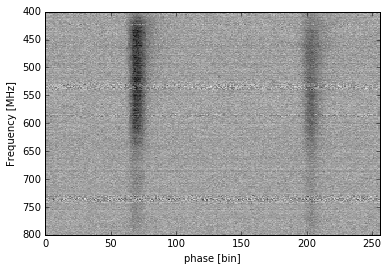

In [7]:
'''
Get Stokes I from real data, as initial condition for simulation
'''

#n = np.load('data/Crab_Foldedspec.npy')
n = np.load('data/B1937_Foldedspec.npy')

#Catalogue value of RM for initial guess
#RM = -43 #Crab
RM = 6.7 #B1937
plt.imshow(n[:,:,(0,3)].sum(-1),aspect='auto',extent=[0,n.shape[1],800,400], interpolation='nearest',cmap=cm.Greys )
plt.xlabel('phase [bin]')
plt.ylabel('Frequency [MHz]')

#plt.savefig('/home/ramain/Dropbox/PhD/GroupMeetings/2015/December/Polarization/6par_Calibration/b1937_foldspec.png')

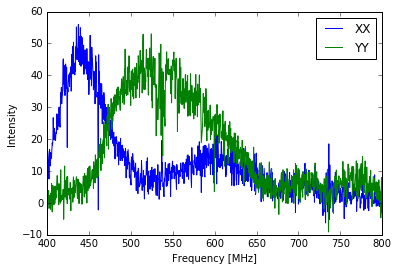

In [8]:
#MPspec = n[:,-5:-1,:].sum(1) # Crab Main Pulse
#MPspec = n[:,46:51,:].sum(1) # Crab Interulse
#MPspec = n[:,115:124,:].sum(1) # Crab Precursor

MPspec = n[:,60:75,:].sum(1) # B1937 Main Pulse
#MPspec = n[:,195:210,:].sum(1) # B1937 Interulse
#MPspec = np.flipud(np.load('../../../data/crab/coherent_pulses/pulse_pcal.npy'))

#MPspec= np.load('data/GPbrightest.npy')

BGspec = np.load('data/Background.npy')
#BGspec = np.load('data/BackgroundB1937.npy')

I, Q, U, V = StokesPars(MPspec)
freq = np.linspace(400,800,1025)[:-1]
lam = (300. / freq)

plt.plot(freq, MPspec[:,0], label='XX')
plt.plot(freq, MPspec[:,3], label='YY')
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity')

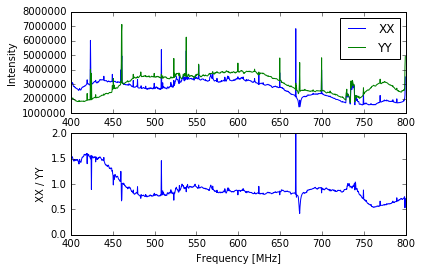

In [9]:
'''
Look at the X and Y response by plotting up the background
'''

plt.subplot(211)
plt.plot(freq, BGspec[:,0], label='XX')
plt.plot(freq, BGspec[:,3], label='YY')
plt.legend()
plt.ylabel('Intensity')

plt.subplot(212)
plt.plot(freq, BGspec[:,0] / BGspec[:,3])
plt.ylim((0,2))

plt.xlabel('Frequency [MHz]')
plt.ylabel(' XX / YY ')

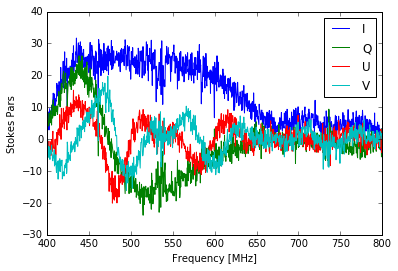

In [10]:
plt.plot(freq, I, label='I')
plt.plot(freq, Q, label='Q')
plt.plot(freq, U, label='U')
plt.plot(freq, V, label='V')

plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Stokes Pars')

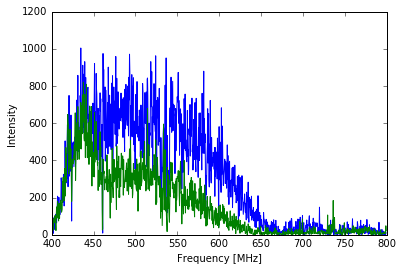

In [11]:
'''
Compare Polarized to Unpolarized flux
        I^2          Q^2 + U^2 + V^2
'''

plt.plot(freq, I**2.0, label='Total intensity')
plt.plot(freq, Q**2.0 + U**2.0 + V**2.0, label='Polarized Emission')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity')

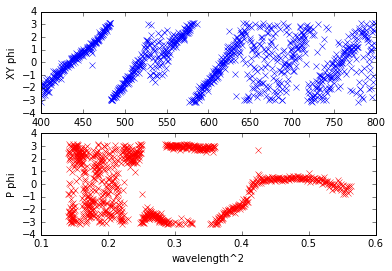

In [12]:
# Look at the phases of P and XY
P = Q + 1j*U
XY = U + 1j*V

XYphi = np.angle(XY)
Pphi = np.angle(P)

plt.subplot(211)
plt.plot(freq, np.angle(XY), 'bx')
plt.xlabel('frequency [MHz]')
plt.ylabel('XY phi')

plt.subplot(212)
plt.plot(lam**2.0, np.angle(P), 'rx')
plt.xlabel('wavelength^2')
plt.ylabel('P phi')

(0, 2)

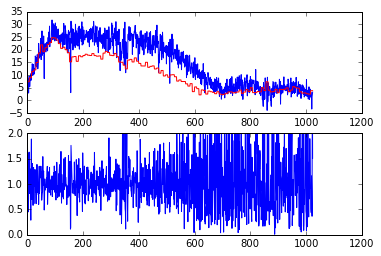

In [13]:
binf = 8
#Ibin = I.reshape(len(I)/binf,binf).mean(-1)  # Response of total intensity
Ibin = np.sqrt(Q**2.0+U**2.0+V**2.0).reshape(len(I)/binf,binf).mean(-1)  # Response of Q^2 + U^2 + V^2
Ical = np.repeat(Ibin, binf)
plt.subplot(211)
plt.plot(I)
plt.plot(Ical,'r')

plt.subplot(212)
plt.plot((Q**2.0 + U**2.0 + V**2.0) / Ical**2.0)
plt.ylim((0,2))

('Peak delay:', 5)


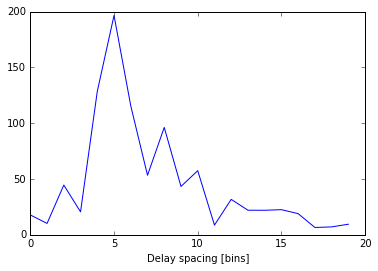

In [14]:
"""
Find a good starting guess for the Cable delay from the FFT of XY
"""

XYnorm = (U + 1j*V) / Ical
FT = np.fft.rfft(np.imag(XYnorm))
FTfreq = np.fft.rfftfreq(len(V))
plt.plot(abs(FT)[:20])
plt.xlabel('Delay spacing [bins]')

lag = np.argmax(abs(FT))
print("Peak delay:", lag)


('Best fit RM, phase:', 6.1904882865242943, -0.16020164779177468)


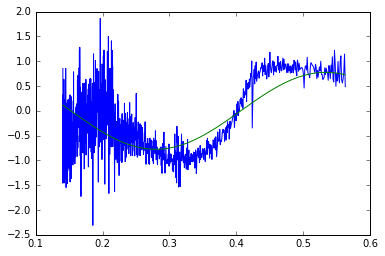

In [15]:
pars = np.array([1, RM, 0])
RM_pars = so.leastsq(RM_fit, pars, args=(Q / Ical, lam), maxfev=10000)[0]

RM_0 = RM_pars[1]
phi_0 = RM_pars[2]
print("Best fit RM, phase:",RM_0, phi_0)

plt.plot(lam**2.0, Q / Ical)
plt.plot(lam**2.0, np.real(RM_pars[0] * np.exp(2j * (RM_0 * lam**2 + phi_0))))

('Q, U, V, lag, RM, phase = ', array([ 0.19578598, -0.88610946,  0.16895016,  5.44653129,  6.25904141,
        0.26283143]))


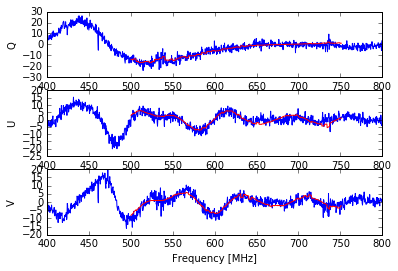

In [16]:
p0 = np.array([2, 1, 0, lag, RM_0, phi_0])
data = np.array([Q,U,V])

bounds=slice(256,900)
b_fit = so.leastsq(DiffData, p0, args=(data, Ical, bounds), maxfev=10000)[0]
print("Q, U, V, lag, RM, phase = ",b_fit)

q, u, v = MockData(b_fit, Ical, bounds)

%matplotlib inline

plt.subplot(311)
plt.plot(freq, Q)
plt.plot(freq[bounds], q, 'r')
plt.ylabel('Q')

plt.subplot(312)
plt.plot(freq, U) 
plt.plot(freq[bounds], u, 'r')
plt.ylabel('U')

plt.subplot(313)
plt.plot(freq, V)
plt.plot(freq[bounds], v, 'r')
plt.ylabel('V')
plt.xlabel('Frequency [MHz]')

In [17]:
'''
Apply first cable delay solution to XY = U + iV,
then Faraday rotation to P = Q + iU
'''

vecCD = np.exp(-2j*np.pi*(np.arange(1024)/1024. * b_fit[3]))
vecFR = np.exp(-2j * (b_fit[4]*lam**2.0 + b_fit[5]))
         
XYcorr = XYnorm*vecCD*Ical
U_CD = np.real(XYcorr)
V_final = np.imag(XYcorr)

Pnorm = (Q + 1j*U_CD) / Ical
Pcorr = Pnorm * vecFR * Ical

V_final = np.imag(XYcorr)
Q_final = np.real(Pcorr)
U_final = np.imag(Pcorr)

#plt.plot(freq, Q_final)
#plt.plot(freq, U_final)
#plt.plot(freq, V_final)
#plt.xlabel('Frequency [MHz]')

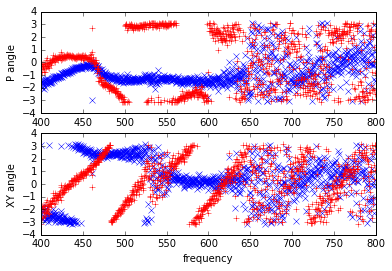

In [18]:
%matplotlib inline
plt.subplot(211)
plt.plot(freq, np.angle(Pcorr), 'bx', label='After removing FR and CD')
plt.plot(freq, np.angle(P), 'r+', label='Initial P')

plt.ylabel('P angle')
plt.xlabel('lambda^2')

plt.subplot(212)
plt.plot(freq, np.angle(XYcorr), 'bx', label='After removing FR and CD')
plt.plot(freq, np.angle(XY), 'r+', label='Initial XY')


plt.ylabel('XY angle')
plt.xlabel('frequency')

('|P| / I = ', 9.5719433340158222)
('Pol angle = ', -1.0812652577426696)


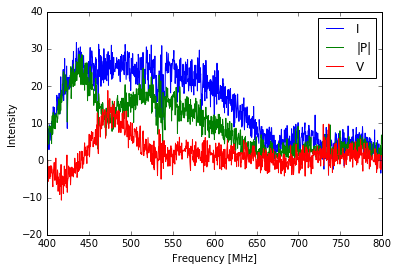

In [19]:
"""
Update Q and U, should now have finished product
"""

Q_CD_FR = np.real(Pcorr)
U_CD_FR = np.imag(Pcorr)

Pfrac = abs(Pcorr*Ical).sum() / I.sum()
Pangle = np.angle(Pcorr.sum())

print("|P| / I = ", Pfrac)
print("Pol angle = ", Pangle)

plt.plot(freq,I,label='I')
plt.plot(freq,abs(Pcorr),label='|P|')
plt.plot(freq,V_final,label='V')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity')
plt.legend()

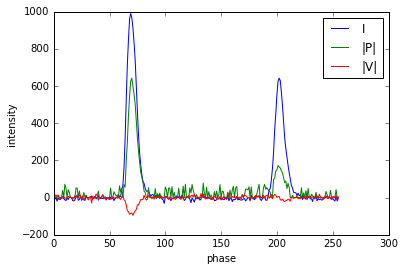

In [23]:
"""
Compare folded spectrum
"""
frange=slice(256,820)

#n2=np.roll(n, 120, axis=1)[frange]
n2=n[frange]

nI, nQ, nU, nV = StokesPars(n2)

nXY = nU + 1j*nV
nXY_CD = nXY * vecCD[frange,np.newaxis]
nU_CD = np.real(nXY_CD)
nV_final = np.imag(nXY_CD)

nP = nQ + 1j*nU_CD
nPderot = nP * vecFR[frange,np.newaxis]

nQ_final = np.real(nPderot)
nU_final = np.imag(nPderot)

"""
Remove noise from P, non-trivial since noise is added then squared
"""

Psq = (abs(nPderot).sum(0))**2.0
Pnoise_sq = np.mean((abs(nPderot[:,100:150]).sum(0))**2.0)
Psq -= Pnoise_sq
Psq = Psq.clip(min=0)
Psq = np.sqrt(Psq)

plt.plot(nI.sum(0), label='I')
plt.plot(Psq, label='|P|' )
plt.plot(-nV_final.sum(0), label='|V|' )

plt.legend()
plt.xlabel('phase')
plt.ylabel('intensity')

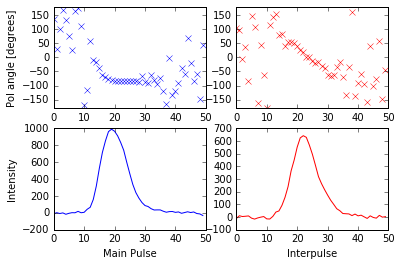

In [24]:
"""
Look at polarization angle
"""

plt.subplot(221)
plt.plot(180/np.pi * np.angle(nPderot.sum(0))[50:100], 'bx') # B1937
#plt.plot(180/np.pi * np.angle(nPderot.sum(0))[5:25], 'bx') # Crab
plt.ylabel('Pol angle [degrees]')
plt.ylim((-180,180))

plt.subplot(222)
plt.plot(180/np.pi * np.angle(nPderot.sum(0))[180:230], 'rx') # B1937
#plt.plot(180/np.pi * np.angle(nPderot.sum(0))[65:75], 'rx') # Crab
plt.ylim((-180,180))

plt.subplot(223)
plt.plot(nI.sum(0)[50:100]) # B1937
#plt.plot(nI.sum(0)[5:25])
plt.ylabel('Intensity') 
plt.xlabel('Main Pulse')

plt.subplot(224)
#plt.plot(nI.sum(0)[180:230],'r')
plt.plot(nI.sum(0)[180:230],'r')
plt.xlabel('Interpulse')

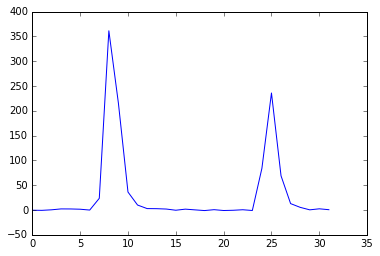

In [15]:
SNspec = n[:,:,(0,3)].sum(-1).sum(0)

SNspec = SNspec.reshape(-1,8).sum(-1)

SNspec = (SNspec - SNspec[120//8:170//8].mean()) / SNspec[120//8:170//8].std()

plt.plot(SNspec)